In [1]:
#importing necessary classes and modules
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Dense, Flatten, Reshape, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
import pandas as pd
import matplotlib.pyplot as plt

import kagglehub
#getting our dataset from kaggle
path = kagglehub.dataset_download("gsimonx37/backloggd")
print("Path to dataset files:", path)


# Use the path from the kagglehub.dataset_download output
base_path = path # path is the variable from the previous cell
#loading the genres and the games
genres = pd.read_csv(f"{base_path}/genres.csv")
games = pd.read_csv(f"{base_path}/games.csv")

100%|██████████| 2.93G/2.93G [00:32<00:00, 95.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gsimonx37/backloggd/versions/3


In [2]:
#getting our top 10 genres that we will use in training/testing our model
genre_counts = (
    genres["genre"]
    .value_counts()
    .reset_index(name="count")
    .rename(columns={"index": "genre"})
)

print(genre_counts.head(10))

       genre  count
0      Indie  58720
1  Adventure  55918
2  Simulator  26254
3        RPG  25019
4   Strategy  24493
5    Shooter  20062
6     Puzzle  19568
7     Arcade  16696
8   Platform  15287
9      Sport  11343


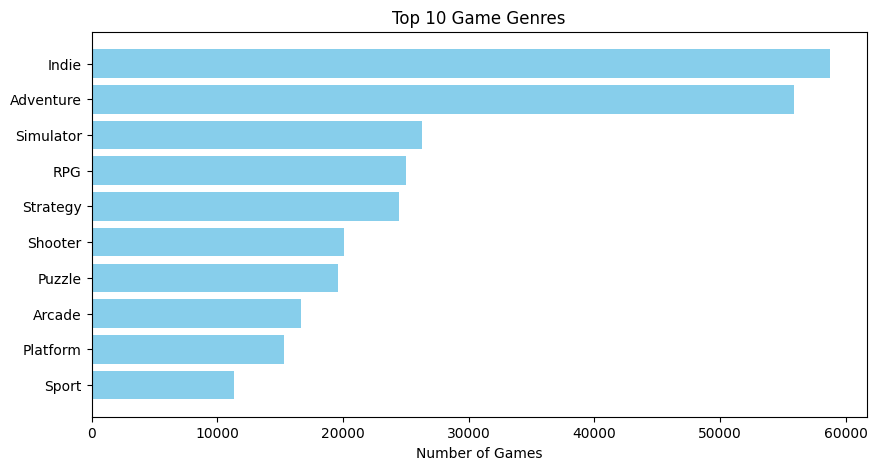

In [3]:
#graph to visualize the data printed above (how many games are in each genre)
top_10 = genre_counts.head(10)

plt.figure(figsize=(10,5))
plt.barh(top_10["genre"], top_10["count"], color="skyblue")
plt.xlabel("Number of Games")
plt.title("Top 10 Game Genres")
plt.gca().invert_yaxis()
plt.show()


In [4]:
#merging the genre data with the games data so we can get games per year by genre
genres_games = genres.merge(
    games,
    left_on="id",
    right_on="id",
    suffixes=('_genre', '_game')
)
genres_games["date"] = pd.to_datetime(
    genres_games["date"],
    errors='coerce'
)

#dropping any missing dates
genres_games = genres_games.dropna(subset=["date"])

#extracting the year from our merged datasets
genres_games["year"] = genres_games["date"].dt.year

#printing the amount of games per year per genre
year_genre_counts = (
    genres_games
    .groupby(["year", "genre"])
    .size()
    .reset_index(name="count")
)

print(year_genre_counts.head())


   year            genre  count
0  1947  Point-and-Click      1
1  1950           Puzzle      1
2  1950         Tactical      1
3  1951          Pinball      1
4  1951         Strategy      1


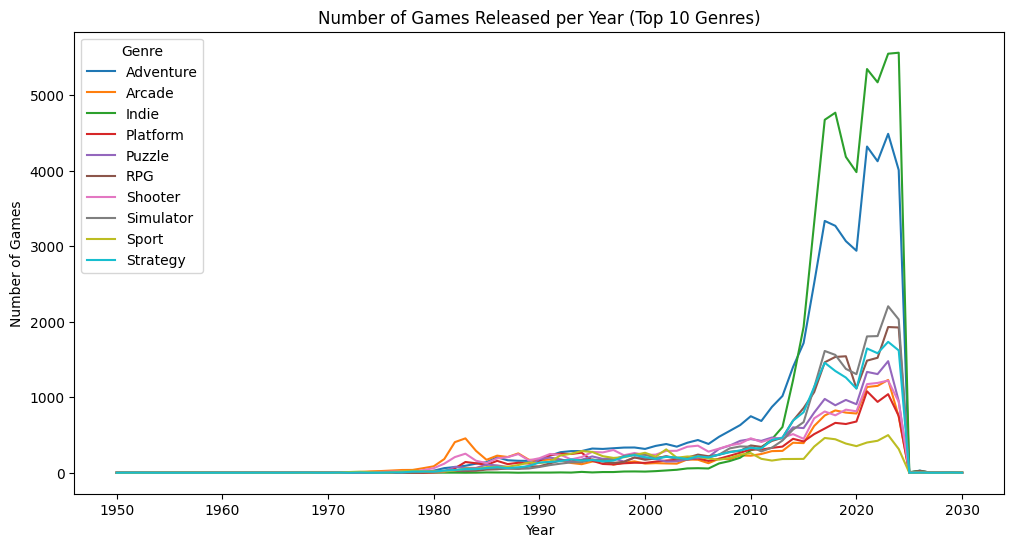

In [5]:
#graphing the number of games released per year, separated into the top 10 genres
top_genres = genre_counts.head(10)["genre"].tolist()
filtered = year_genre_counts[year_genre_counts["genre"].isin(top_genres)]
pivoted = filtered.pivot(
    index="year",
    columns="genre",
    values="count"
).fillna(0)
pivoted.plot(figsize=(12,6))
plt.title("Number of Games Released per Year (Top 10 Genres)")
plt.ylabel("Number of Games")
plt.xlabel("Year")
plt.legend(title="Genre")
plt.show()


In [6]:
genres_games.drop(['rating', 'reviews', 'plays', 'playing', 'backlogs', 'date', 'wishlists', 'description'], axis=1, inplace=True)
print(genres_games.head())

        id            genre                               name  year
0  1000001  Point-and-Click  Cathode Ray Tube Amusement Device  1947
1  1000002           Puzzle                   Bertie the Brain  1950
2  1000002         Tactical                   Bertie the Brain  1950
3  1000003          Pinball                                Nim  1951
4  1000003         Strategy                                Nim  1951


In [7]:
#narrowing our data down to only games from 2015 to 2025
games_filtered = genres_games[genres_games["year"] >= 2015].copy()

top_genre = (
    games_filtered["genre"]
    .value_counts()
    .head(10)
    .index
    .tolist()
)
games_filtered = games_filtered[
    games_filtered["genre"].isin(top_genre)
].copy()

#shape = (number of games in dataset, parameters [id, genre, name, year])
print(games_filtered.shape)
print(games_filtered.head())
print("Number of games from 2015-2025 that are part of the top 10 genres: ")
print(len(games_filtered))

(162508, 4)
            id         genre  \
12714  1010260        Arcade   
12715  1010260       Shooter   
62104  1047763     Adventure   
62106  1047763        Puzzle   
62107  1047763  Visual Novel   

                                                    name  year  
12714                                             Gynoug  2021  
12715                                             Gynoug  2021  
62104  Phoenix Wright: Ace Attorney - The Contempt of...  2017  
62106  Phoenix Wright: Ace Attorney - The Contempt of...  2017  
62107  Phoenix Wright: Ace Attorney - The Contempt of...  2017  
Number of games from 2015-2025 that are part of the top 10 genres: 
162508


In [8]:
#balancing our dataset by getting 100 games per genre per year, for 1,000 games per year and 10,000  games total
#the actual shape of the data is 10,135, because if some groups by genre/year had less than 100 games all of them were included.
sampled_games = games_filtered.groupby(['genre', 'year']).apply(
    lambda x: x.sample(n=100, replace=False) if len(x) >= 100 else x
).reset_index(drop=True)

print(sampled_games.shape)
print(sampled_games.head())

(10135, 4)
        id      genre                                               name  year
0  1072551  Adventure                                             Frizzy  2015
1  1067591  Adventure                                 Hatland Adventures  2015
2  1067380  Adventure                           The Splitting: Chapter 1  2015
3  1069105  Adventure  8-Bit Adventures: The Forgotten Journey - Rema...  2015
4  1069730  Adventure                                      Secrets of Me  2015


/tmp/ipython-input-8-1491164412.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_games = games_filtered.groupby(['genre', 'year']).apply(


In [9]:
import os
from sklearn.preprocessing import LabelEncoder

#getting the poster id numbers
poster_dir = os.path.join(path, "posters")
poster_files = os.listdir(poster_dir)

#the id numbers are just the file names, so we remove the .jpg from the name
poster_ids = [int(f.replace(".jpg","")) for f in poster_files if f.endswith(".jpg")]
print(len(poster_ids))

#converting our genre string labels into integer labels
le = LabelEncoder()
sampled_games["label"] = le.fit_transform(sampled_games["genre"])
print(sampled_games[["genre", "label"]].drop_duplicates())

179846
             genre  label
0        Adventure      0
1037        Arcade      1
2038         Indie      2
3078      Platform      3
4083        Puzzle      4
5085           RPG      5
6115       Shooter      6
7118     Simulator      7
8125      Strategy      8
9129  Visual Novel      9


In [10]:
#this is redundant code - but it remains atm so our models still run </3
import os
poster_dir = os.path.join(path, "posters")
poster_files = os.listdir(poster_dir)
available_ids = set(
    int(fname.replace(".jpg", ""))
    for fname in poster_files
    if fname.endswith(".jpg") and fname.replace(".jpg", "").isdigit()
)

print(f"{len(available_ids)} poster images available.")

179846 poster images available.


In [11]:
#creating a multi-hot encoding vector so that each videogame/poster can correspond to multiple genres
#ex - if a game was in both the adventure (label 0) and shooter (label 6) genres, its vector would be:
# [1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
def to_multihot(label_list, num_classes):
    vec = np.zeros(num_classes)
    vec[label_list] = 1
    return vec

In [12]:
#MATCHING POSTERS AND GENRE IMAGES

#keeping only games/genres with matching poster id's (not all of the games in our dataset had posters)
genres_with_images = sampled_games[
    sampled_games["id"].isin(available_ids)
].copy()

#for get the genre(s) for each game into a list, put into the "labels" column
#ex - if a game has both is both action and shooter its label will be [0, 6]
genre_lists = genres_with_images.groupby("id")["label"].apply(list).reset_index()
genre_lists.rename(columns={"label": "labels"}, inplace=True)

#removing duplicate game entries because we have now combined their labels
metadata = genres_with_images.drop_duplicates("id")

#merging our data back together so that we have only 1 entry for each game that has a poster image
#and its corresponding genre labels
genres_with_images = metadata.merge(genre_lists, on="id")
genres_with_images.drop(['genre', 'label'], axis=1, inplace=True)

#print our complete data!
print("First 10 rows of genres_with_images:")
print(genres_with_images.head(10))
print(f"{genres_with_images.shape[0]} games with matching images.")

First 10 rows of genres_with_images:
        id                                               name  year     labels
0  1072551                                             Frizzy  2015  [0, 2, 3]
1  1067591                                 Hatland Adventures  2015     [0, 3]
2  1069105  8-Bit Adventures: The Forgotten Journey - Rema...  2015        [0]
3  1069730                                      Secrets of Me  2015     [0, 9]
4  1070788                              Cross of the Dutchman  2015        [0]
5  1069888                                      Seep Universe  2015     [0, 3]
6  1069525     Batman: Arkham Knight - Batman Flashpoint Skin  2015        [0]
7  1070671               Metal Gear Solid V: The Phantom Pain  2015        [0]
8  1067905                               The World Named Fred  2015     [0, 2]
9  1072064                                       After School  2015        [0]
9034 games with matching images.


In [13]:
#splitting our data into training and testing
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    genres_with_images,
    test_size=0.2,
    random_state=42
)
print(train_df.shape, test_df.shape)

(7227, 4) (1807, 4)


In [14]:
train_df_1 = train_df.head(3500)
test_df_1 = test_df.head(900)

In [15]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

IMG_SIZE = (224, 224)

def load_images(df, poster_dir, num_classes):
    X = []
    y = []

#loops through each game, gets its ID number and genre labels
    for _, row in df.iterrows():
        game_id = row["id"]
        label_list = row["labels"]
#converts the label list into a one hot encoding vector ([1, 6] -> [1, 0, 0, 0, 0, 0, 1, 0, 0, 0])
        multi_hot_label = np.zeros(num_classes)
        multi_hot_label[label_list] = 1

        image_path = os.path.join(poster_dir, f"{game_id}.jpg")

#loads the image and resizes it to 224, 224
#converts the image to a numpy array and normalizes pixel values to [0, 1].
        try:
            img = load_img(image_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0
            X.append(img_array)
            y.append(multi_hot_label)

        except Exception as e:
            print(f"Error loading {image_path}: {e}")

#returning:
  #the array of images (X) withshape: [number of samples, 224, 224, 3])
  #the array of multi-hot vectors (y) (shape: [number of samples, genres])
    return np.array(X), np.array(y)

In [16]:
#preparing our training and testing data
num_classes = sampled_games['label'].max() + 1

X_train, y_train = load_images(train_df_1, poster_dir, num_classes=num_classes)
X_test, y_test = load_images(test_df_1, poster_dir, num_classes=num_classes)

#printing their shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3500, 224, 224, 3)
y_train shape: (3500, 10)
X_test shape: (900, 224, 224, 3)
y_test shape: (900, 10)


In [24]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.applications import MobileNetV2

num_filters = 10
filter_size = 3
pool_size = 2
input_shape = (224, 224, 3)

base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'accuracy', tf.keras.metrics.AUC(name='auc')])

In [28]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.1056 - auc: 0.5030 - binary_accuracy: 0.7802 - loss: 1.5228 - val_accuracy: 0.1314 - val_auc: 0.5426 - val_binary_accuracy: 0.8957 - val_loss: 0.3819
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.1275 - auc: 0.5261 - binary_accuracy: 0.8710 - loss: 0.4804 - val_accuracy: 0.1343 - val_auc: 0.5480 - val_binary_accuracy: 0.8960 - val_loss: 0.3881
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.1277 - auc: 0.5277 - binary_accuracy: 0.8793 - loss: 0.4669 - val_accuracy: 0.1157 - val_auc: 0.5302 - val_binary_accuracy: 0.8959 - val_loss: 0.3964
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.1353 - auc: 0.5330 - binary_accuracy: 0.8928 - loss: 0.4193 - val_accuracy: 0.1157 - val_auc: 0.5241 - val_binary_accuracy: 0.8963 - val_loss: 0.3495
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.1437 - auc: 0.5543 - binary_accuracy: 0.8940 - loss: 0.3575 - val_accuracy:

In [29]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    32,113,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,999,136 (377.65 MB)

 Trainable params: 32,247,050 (123.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 64,494,102 (246.03 MB)

In [30]:
test_loss, binary_accuracy, accuracy, auc = model.evaluate(X_test, y_test, batch_size=100)

print("Binary Accuracy:", binary_accuracy)
print("Accuracy:", accuracy)
print("AUC:", auc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.1465 - auc: 0.5566 - binary_accuracy: 0.8945 - loss: 0.3319
Binary Accuracy: 0.8941110372543335
Accuracy: 0.1366666704416275
AUC: 0.5433875322341919


29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step


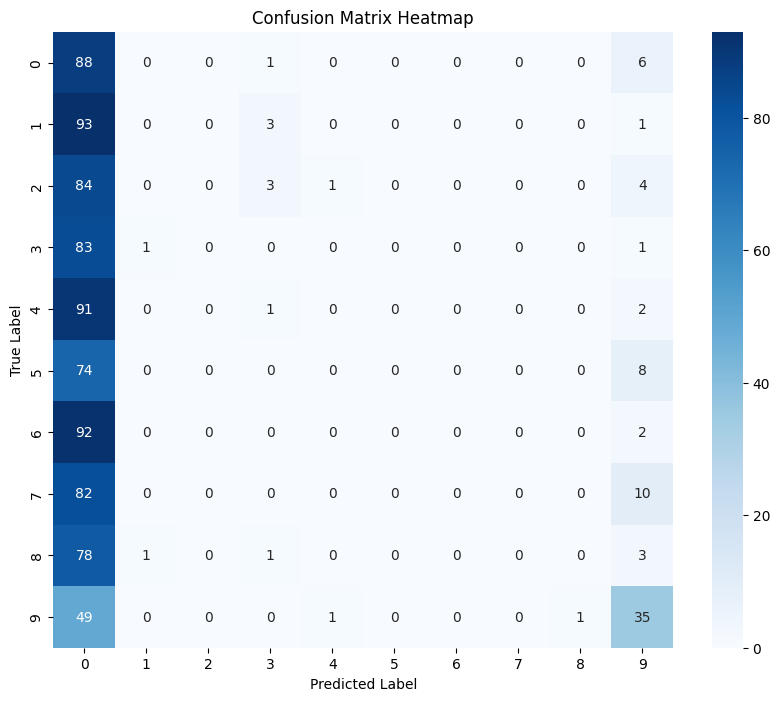

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred_probs = model.predict(X_test)
pred_classes = np.argmax(pred_probs, axis=1)

true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot
plt.figure(figsize=(10, 8))  # adjust size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [33]:
train_df_2 = train_df[3500:]
test_df_2 = test_df[900:]

In [34]:
num_classes = sampled_games['label'].max() + 1

X_train, y_train = load_images(train_df_2, poster_dir, num_classes=num_classes)
X_test, y_test = load_images(test_df_2, poster_dir, num_classes=num_classes)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3698, 224, 224, 3)
y_train shape: (3698, 10)
X_test shape: (900, 224, 224, 3)
y_test shape: (900, 10)


In [35]:
history2 = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.1224 - auc: 0.5176 - binary_accuracy: 0.8951 - loss: 0.3406 - val_accuracy: 0.1108 - val_auc: 0.5369 - val_binary_accuracy: 0.8951 - val_loss: 0.3336
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.1267 - auc: 0.5191 - binary_accuracy: 0.8949 - loss: 0.3390 - val_accuracy: 0.0959 - val_auc: 0.5091 - val_binary_accuracy: 0.8947 - val_loss: 0.3361
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.1141 - auc: 0.5243 - binary_accuracy: 0.8950 - loss: 0.3383 - val_accuracy: 0.0973 - val_auc: 0.5142 - val_binary_accuracy: 0.8947 - val_loss: 0.3356
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.1110 - auc: 0.5225 - binary_accuracy: 0.8946 - loss: 0.3389 - val_accuracy: 0.0932 - val_auc: 0.5002 - val_binary_accuracy: 0.8946 - val_loss: 0.3363


In [36]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    32,113,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,999,136 (377.65 MB)

 Trainable params: 32,247,050 (123.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 64,494,102 (246.03 MB)

In [37]:
test_loss, binary_accuracy, accuracy, auc = model.evaluate(X_test, y_test, batch_size=100)

print("Binary Accuracy:", binary_accuracy)
print("Accuracy:", accuracy)
print("AUC:", auc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.1150 - auc: 0.5270 - binary_accuracy: 0.8959 - loss: 0.3307
Binary Accuracy: 0.8958888053894043
Accuracy: 0.12111110985279083
AUC: 0.5365788340568542


29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step


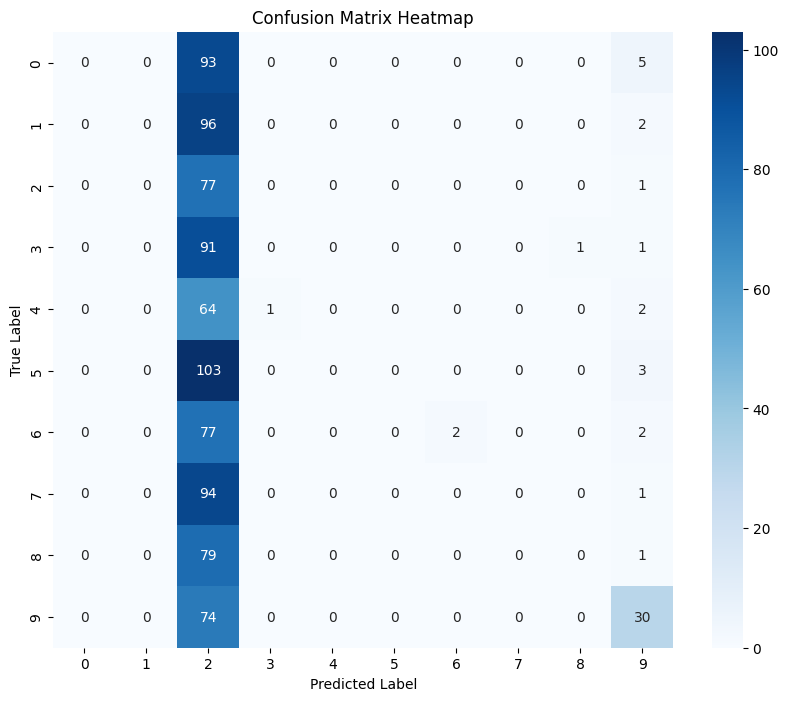

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred_probs = model.predict(X_test)
pred_classes = np.argmax(pred_probs, axis=1)

true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot
plt.figure(figsize=(10, 8))  # adjust size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()